In [7]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset, split_train_val, prepare_test_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained, upload_pretrained_vit, upload_pretrained_densenet121
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.models as models
import pickle
import lime


### Pre-processing

In [8]:
class_names = ['Pleural Effusion']
policies = ['ones', 'zeroes', 'mixed']
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


# Import the validation dataset as final test set
test_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Prepare the test dataset using the last policy in the list and the defined class names
test_image_paths, test_label_matrix = prepare_dataset(test_df, policies[-1], class_names)

# Create a DataFrame for the test image paths
test_image_paths_df = pd.DataFrame({'path': test_image_paths})

# Create a DataFrame for the test labels with the class names as columns
test_labels_df = pd.DataFrame(test_label_matrix, columns=class_names)

# Combine the test image paths DataFrame and the test labels DataFrame
test_df = pd.concat([test_image_paths_df, test_labels_df], axis=1)


In [9]:
test_df.iloc[1]

path                CheXpert-v1.0-small/valid/patient64634/study1/...
Pleural Effusion                                                    0
Name: 1, dtype: object

#### Uploading the model we trained

In [10]:
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model_densenet121 = upload_pretrained_densenet121(densenet121, add_layers=True, n_labels=len(class_names), freeze_layers=True)
state_dict = torch.load("model_densenet121.pth", map_location=torch.device('cpu'))



#### DataLoader object

In [11]:
test_dataset = CheXpertDataset(test_df, class_names, transform=transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
from evaluation_utils import evaluate_model

criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model_densenet121, test_loader, criterion)

NameError: name 'DataLoader' is not defined

In [73]:
# Load a test image from testloader
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0]  # Select the first image
true_label = labels[0].item()


img.shape

torch.Size([3, 224, 224])

  0%|          | 0/1000 [00:00<?, ?it/s]

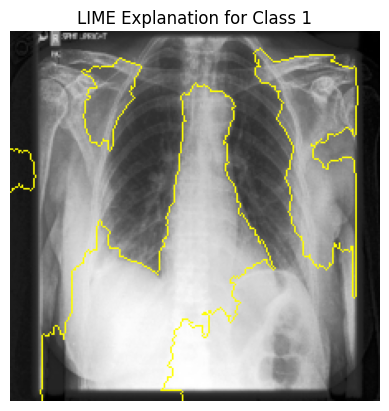

In [75]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from PIL import Image

# Ensure your model is in evaluation mode and on the proper device.
model_densenet121.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet121.to(device)

# Helper: convert a PyTorch image tensor to a NumPy array normalized to [0,1]
def preprocess_img(img_tensor):
    # Assuming img_tensor is of shape (C, H, W)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    return img_np

# Assuming you have obtained an image from your testloader:
# For example, grabbing the first image from a batch:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0]  # select the first image from the batch
img_np = preprocess_img(img)

# Prediction function for LIME:
def predict_fn(images):
    """
    images: list/array of images in NumPy format (H x W x C), with pixel values in [0, 1].
    Returns: a NumPy array of shape (n_samples, 2) with class probabilities.
    """
    # Convert each LIME image (numpy array) to a PIL image, then to a tensor.
    tensor_images = [
        transforms.ToTensor()(Image.fromarray((img * 255).astype(np.uint8)))
        for img in images
    ]
    # Stack into a single batch tensor of shape (N, C, H, W)
    batch = torch.stack(tensor_images).to(device)
    
    with torch.no_grad():
        outputs = model_densenet121(batch)  # outputs shape: (batch, 1)
        # Apply sigmoid to get probability for class 1.
        probs_class1 = torch.sigmoid(outputs)
        # Create two-class probabilities: class0 = 1 - p, class1 = p.
        probs = torch.cat([1 - probs_class1, probs_class1], dim=1)
    
    return probs.cpu().numpy()

# Create LIME image explainer.
explainer = LimeImageExplainer()

# Explain the prediction for the chosen image.
# For binary classification, we can set top_labels=2 or even explicitly request a particular label.
explanation = explainer.explain_instance(
    img_np.astype("double"),   # LIME expects a double precision image array.
    predict_fn,
    top_labels=2,              # With binary classification, there are two labels.
    hide_color=0,
    num_samples=1000           # Number of perturbed samples
)

# Choose the label you wish to explain. For example, to explain class 1 (positive class):
label_to_explain = 1  # or use explanation.top_labels[0] if that suits your needs

# Get the explanation mask.
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=10,
    hide_rest=False
)

# Visualize the explanation.
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Class {label_to_explain}")
plt.axis("off")
plt.show()


In [31]:
import torch
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    hamming_loss,
    classification_report
)

# Convert predictions to binary values based on a threshold (0.5)
predicted_labels = (predictions > 0.5).int()

# Convert tensors to numpy arrays for sklearn metrics
true_labels_np = true_labels.numpy()
predicted_labels_np = predicted_labels.numpy()

# 1. Accuracy 
subset_accuracy = accuracy_score(true_labels_np, predicted_labels_np)
print("Multi-label subset accuracy:", subset_accuracy)

# 2. Calculate precision, recall, and F1 score using 'samples', 'macro' and 'micro' averaging
precision_samples = precision_score(true_labels_np, predicted_labels_np, average='samples', zero_division=0)
recall_samples = recall_score(true_labels_np, predicted_labels_np, average='samples', zero_division=0)
f1_samples = f1_score(true_labels_np, predicted_labels_np, average='samples', zero_division=0)

print("Precision (samples average):", precision_samples)
print("Recall (samples average):", recall_samples)
print("F1 Score (samples average):", f1_samples)
print('_________________________________________________________________________________________________________')


precision_macro = precision_score(true_labels_np, predicted_labels_np, average='macro', zero_division=0)
recall_macro = recall_score(true_labels_np, predicted_labels_np, average='macro', zero_division=0)
f1_macro = f1_score(true_labels_np, predicted_labels_np, average='macro', zero_division=0)

print("Precision (macro average):", precision_macro)
print("Recall (macro average):", recall_macro)
print("F1 Score (macro average):", f1_macro)
print('_________________________________________________________________________________________________________')


precision_micro = precision_score(true_labels_np, predicted_labels_np, average='micro', zero_division=0)
recall_micro = recall_score(true_labels_np, predicted_labels_np, average='micro', zero_division=0)
f1_micro = f1_score(true_labels_np, predicted_labels_np, average='micro', zero_division=0)

print("Precision (micro average):", precision_micro)
print("Recall (micro average):", recall_micro)
print("F1 Score (micro average):", f1_micro)
print('_________________________________________________________________________________________________________')


print("\nClassification Report:")
print(classification_report(true_labels_np, predicted_labels_np, zero_division=0))


Multi-label subset accuracy: 0.3465346534653465
Precision (samples average): 0.09900990099009901
Recall (samples average): 0.03118811881188118
F1 Score (samples average): 0.046888260254596886
_________________________________________________________________________________________________________
Precision (macro average): 0.3
Recall (macro average): 0.06726190476190477
F1 Score (macro average): 0.08622540250447228
_________________________________________________________________________________________________________
Precision (micro average): 0.5121951219512195
Recall (micro average): 0.07526881720430108
F1 Score (micro average): 0.13125
_________________________________________________________________________________________________________

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00        66
           2       0.00      0.00      0.00        32
    